In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


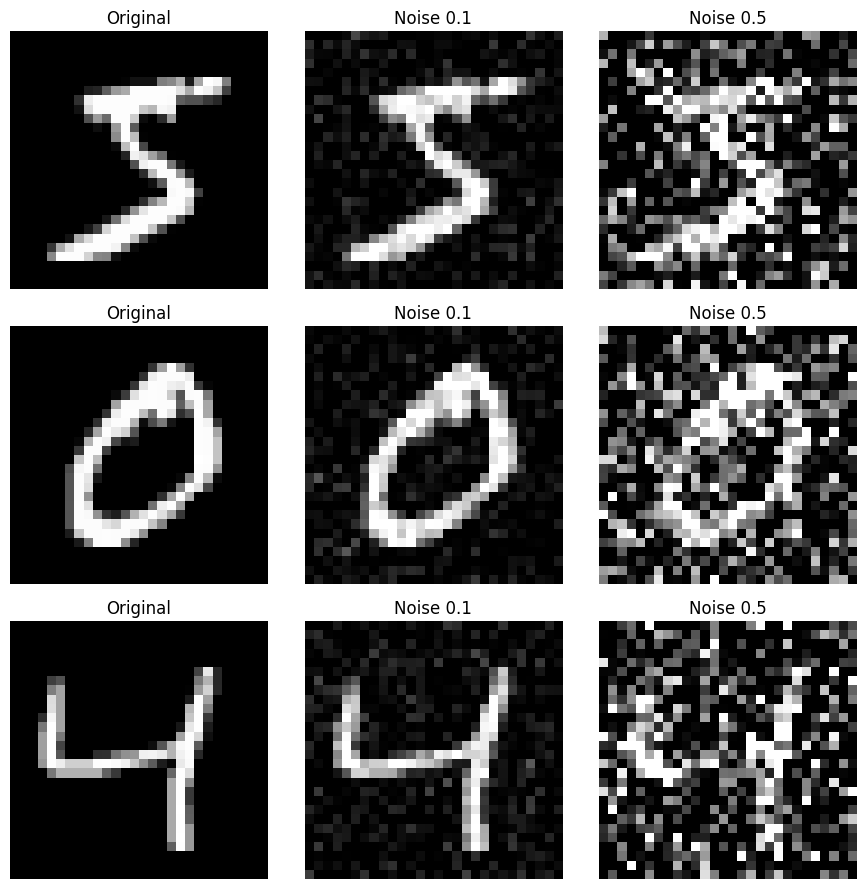

In [3]:
# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)
#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
  # Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
def build_encoder(input_shape=(28, 28, 1)):
  """
  Builds the encoder part of the convolutional autoencoder.
  Parameters:
  input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.
  Returns:
  input_img (Keras Input): Input layer of the model.
  encoded (Keras Tensor): Encoded representation after convolution and pooling.
  """
  input_img = Input(shape=input_shape, name="input")
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
  return input_img, encoded

In [5]:
def build_decoder(encoded_input):
  """
  Builds the decoder part of the convolutional autoencoder.
  Parameters:
  encoded_input (Keras Tensor): The output from the encoder.
  Returns:
  decoded (Keras Tensor): The reconstructed output after upsampling and
  convolution.
  """
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
  return decoded

In [6]:
def build_autoencoder():
  """
  Constructs and compiles the full convolutional autoencoder by connecting encoder and
  decoder.
  Returns:
  autoencoder (Keras Model): Compiled autoencoder model.
  """
  input_img, encoded_output = build_encoder()
  decoded_output = build_decoder(encoded_output)
  autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
  autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
  return autoencoder

In [7]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Conv2D)                │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
x_train_noisy_high, x_train,
epochs=10,
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 225s 475ms/step - loss: 0.2234 - val_loss: 0.1119
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 245s 438ms/step - loss: 0.1107 - val_loss: 0.1049
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 433ms/step - loss: 0.1046 - val_loss: 0.1018
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 257s 423ms/step - loss: 0.1019 - val_loss: 0.0997
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 426ms/step - loss: 0.0999 - val_loss: 0.0980
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 427ms/step - loss: 0.0986 - val_loss: 0.0975
Epoch 7/10
150/469 ━━━━━━━━━━━━━━━━━━━━ 2:09 406ms/step - loss: 0.0979

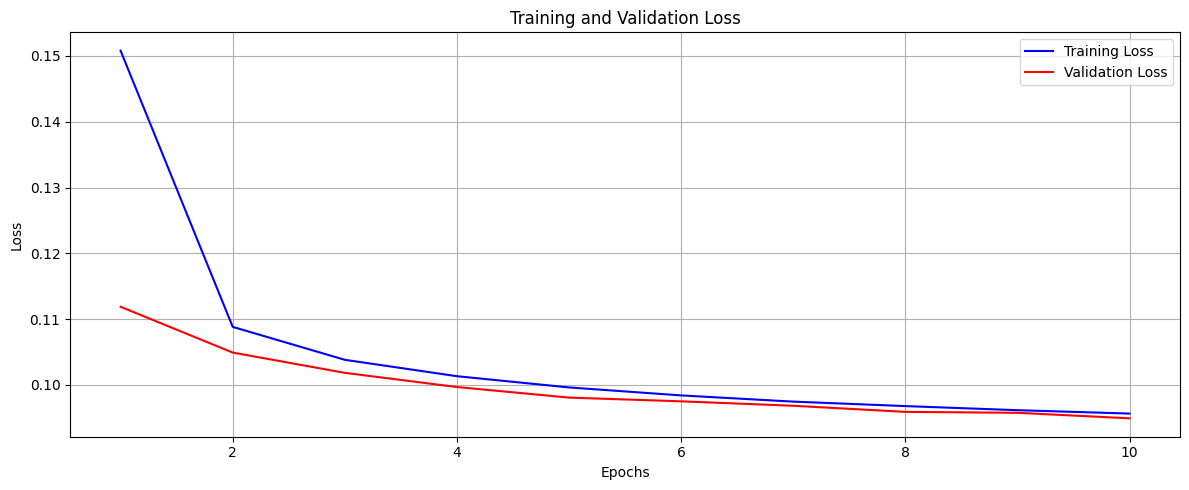

In [9]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step


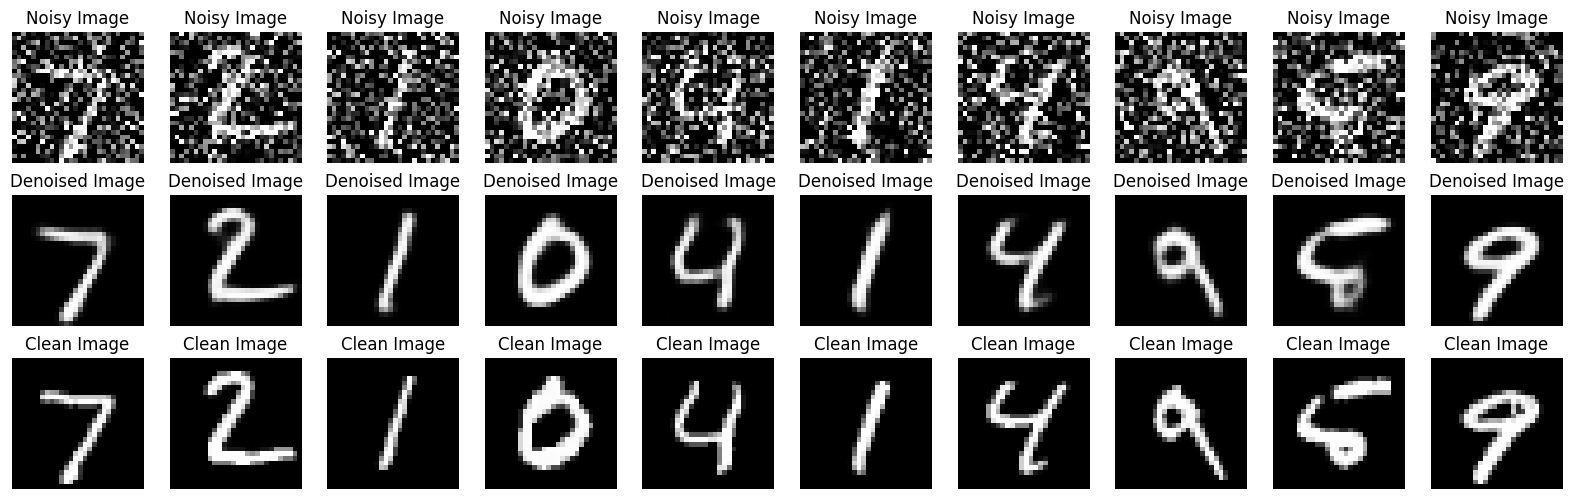

In [10]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
  plt.figure(figsize=(20, 6))
  for i in range(n):
  # Plot noisy images
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    # Plot denoised images
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')
    # Plot clean images
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
    plt.title("Clean Image")
    plt.axis('off')
  plt.show()
# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)

In [11]:
# Define dataset paths
train_dir = "/content/drive/MyDrive/DevanagariHandwrittenDigitDataset/Train"
test_dir = "/content/drive/MyDrive/DevanagariHandwrittenDigitDataset/Test"
# Define image size
img_height, img_width = 28, 28
# Function to load images and labels using PIL
def load_images_from_folder(folder):
  images = []
  labels = []
  class_names = sorted(os.listdir(folder)) # Sorted class names (digit_0, digit_1, ...)
  class_map = {name: i for i, name in enumerate(class_names)} # Map class names to labels
  for class_name in class_names:
    class_path = os.path.join(folder, class_name)
    label = class_map[class_name]
    for filename in os.listdir(class_path):
      img_path = os.path.join(class_path, filename)
      # Load image using PIL
      img = Image.open(img_path).convert("L") # Convert to grayscale
      img = img.resize((img_width, img_height)) # Resize to (28,28)
      img = np.array(img) / 255.0 # Normalize pixel values to [0,1]

      images.append(img)
      labels.append(label)
  return np.array(images), np.array(labels)
# Load training and testing datasets
train_x, train_y = load_images_from_folder(train_dir)
test_x, test_y = load_images_from_folder(test_dir)

In [12]:
def shuffle_data(clean_images, noisy_images_low=None, noisy_images_high=None, random_seed=None):

    if random_seed is not None:
        np.random.seed(random_seed)

    # Generate shuffled indices
    num_samples = clean_images.shape[0]
    indices = np.random.permutation(num_samples)

    # Apply indices to shuffle arrays
    shuffled_clean = clean_images[indices]
    shuffled_noisy_low = noisy_images_low[indices] if noisy_images_low is not None else None
    shuffled_noisy_high = noisy_images_high[indices] if noisy_images_high is not None else None

    return (
        shuffled_clean,
        shuffled_noisy_low if noisy_images_low is not None else None,
        shuffled_noisy_high if noisy_images_high is not None else None
    )


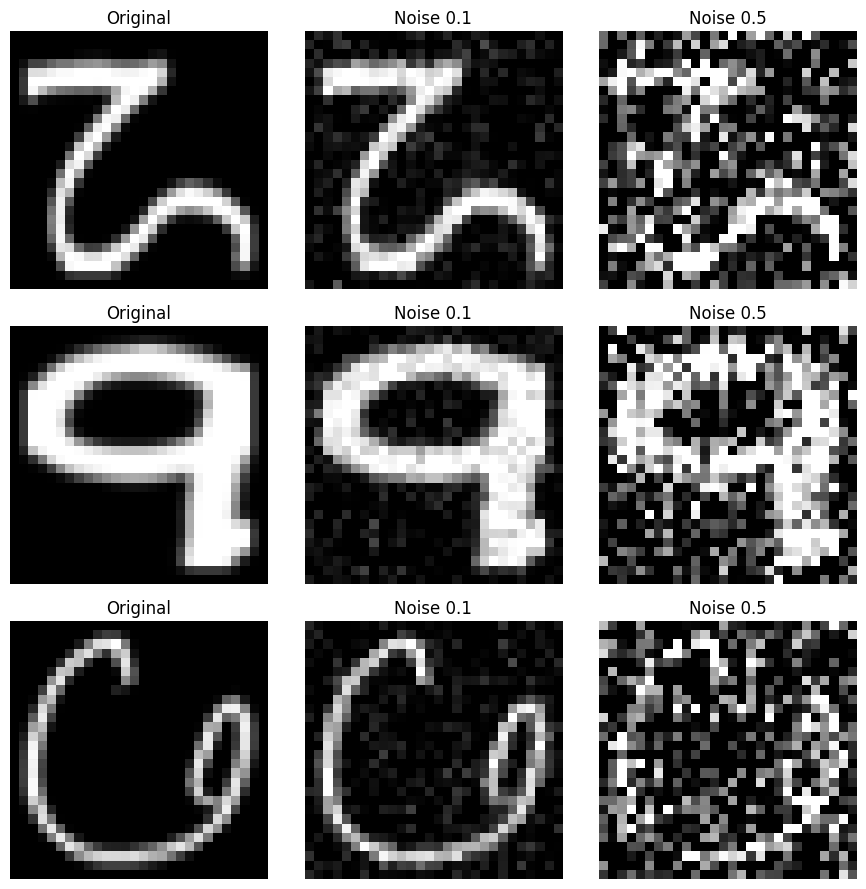

In [13]:

# Load and preprocess MNIST
x_train, x_test = train_x, test_x
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)


x_train, x_train_noisy_low, x_train_noisy_high = shuffle_data(
    x_train, x_train_noisy_low, x_train_noisy_high, random_seed=42
)
x_test, x_test_noisy_low, x_test_noisy_high = shuffle_data(
    x_test, x_test_noisy_low, x_test_noisy_high, random_seed=42
)


#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
  # Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
def build_autoencoder():
    input_img = Input(shape=(28, 28, 1))  # Update to (32, 32, 1) if Devnagari uses 32x32
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [15]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
x_train_noisy_high, x_train,
epochs=10,
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 48s 286ms/step - loss: 0.4770 - val_loss: 0.2387
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - loss: 0.2304 - val_loss: 0.2167
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 269ms/step - loss: 0.2150 - val_loss: 0.2090
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 277ms/step - loss: 0.2086 - val_loss: 0.2069
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 36s 266ms/step - loss: 0.2047 - val_loss: 0.2010
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - loss: 0.2012 - val_loss: 0.2015
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 272ms/step - loss: 0.1985 - val_loss: 0.1963
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - loss: 0.1963 - val_loss: 0.1952
Epoch 9/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 39s 291ms/step - loss: 0.1947 - val_loss: 0.1935
Epoch 10/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 38s 268ms/step - loss: 0.1931 - val_loss: 0.1935


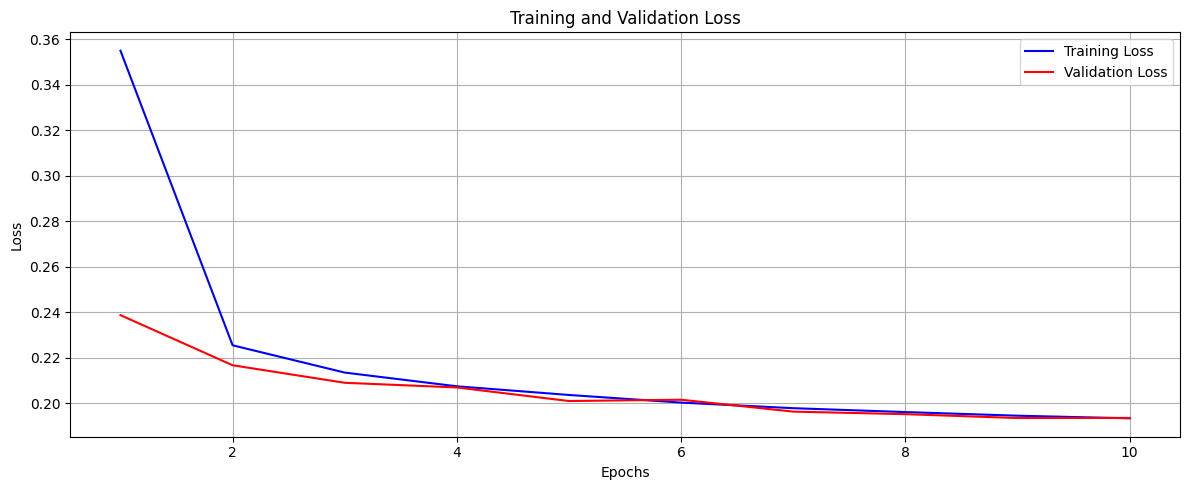

In [17]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


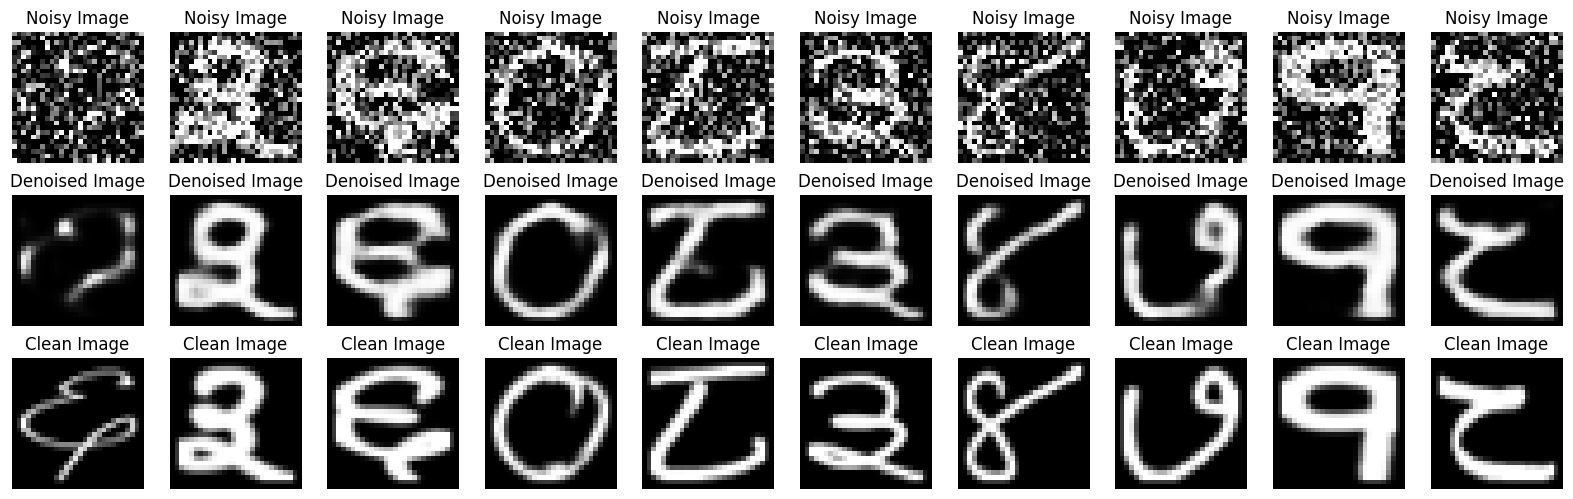

In [18]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
  plt.figure(figsize=(20, 6))
  for i in range(n):
  # Plot noisy images
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    # Plot denoised images
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')
    # Plot clean images
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
    plt.title("Clean Image")
    plt.axis('off')
  plt.show()
# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)